In [1]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials
using Random
using JLD2

In [2]:
function setup(r, seed)
    Random.seed!(seed)
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,2)
    r0[:,:,1] .= 10 .*(rand.())   # Cdc42-GTPm
    r0[:,:,2] .= .2 - mean(r0[:,:,1])*n   # Cdc42-GDPm 
    # THIS VALUE SHIFTS RELATIONSHIP BETWEEN NUMBER OF SITES AND RADIUS
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, R)
    # Actual parameters
    a = 1
    b = 0.25
    Dm = 0.01
    Dc = 10
    n = n

    p = (a, b, Dm, Dc, n, Ax, Ay, dummy)
    return p, r0
end

function simple!(dr,r,p,t)
    a, b, Dm, Dc, n, Ax, Ay, dummy = p
    Ayt, tAx, D42t, D42d, R = dummy
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*rhoT^2*rhoD) - b*rhoT
    @. dr[:,:,1] = R + D42t
    @. dr[:,:,2] = -R*n + D42d
end

function runner(radius, seed)
    p, r0 = setup(radius, seed)
    min_prob = ODEProblem(simple!,r0,(0.0,5),p)
    sol = solve(min_prob,CVODE_BDF(linear_solver = :GMRES), saveat=(5))
    return sol
end

sol_ic = runner(5, 1)

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 0.0
 5.0
u: 2-element Vector{Array{Float64, 3}}:
 [0.7336635446929285 1.670529092877866 … 4.498294423109524 4.346647867723758; 3.4924148955718612 7.197206925405183 … 8.084217249744095 9.244406861511123; … ; 8.338534481533054 3.6131523841038513 … 3.295155127929638 5.904229678435289; 9.817043479487307 3.618757071379193 … 3.1065190965909384 2.26016435978588;;; 0.1699682520866589 0.1699682520866589 … 0.1699682520866589 0.1699682520866589; 0.1699682520866589 0.1699682520866589 … 0.1699682520866589 0.1699682520866589; … ; 0.1699682520866589 0.1699682520866589 … 0.1699682520866589 0.1699682520866589; 0.1699682520866589 0.1699682520866589 … 0.1699682520866589 0.1699682520866589]
 [26.99255931718226 26.01742717923762 … 24.731975248154978 26.313046067262977; 23.81977419942994 22.739278701364874 … 23.235461242358976 23.82865009665038; … ; 63.773940718314186 62.65908842526899 … 47.768097734154665 57.946948750330414; 38

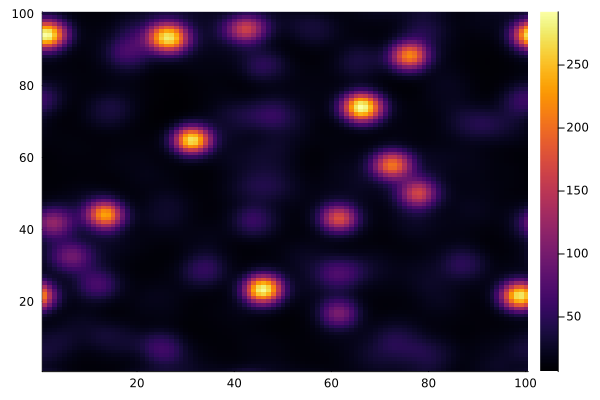

In [3]:
heatmap(sol_ic[:,:,1,2])

In [4]:
function setup(r, sol_ic)
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = sol_ic
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, R)
    # Actual parameters
    a = 1
    b = 0.25
    c = 0.5
    Dm = 0.01
    Dc = 10
    n = n
    tau = 1

    p = (a, b, c, Dm, Dc, n, Ax, Ay, tau, dummy)
    return p, r0
end

setup (generic function with 1 method)

In [5]:
function negfb!(dr,r,h,p,t)
    a, b, c, Dm, Dc, n, Ax, Ay, tau, dummy = p
    Ayt, tAx, D42t, D42d, R = dummy
    hist = h(p, t - tau;idxs = 1)
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*rhoT^2*rhoD) - b*rhoT - c*rhoT*hist
    @. dr[:,:,1] = R + D42t
    @. dr[:,:,2] = -R*n + D42d
end

negfb! (generic function with 1 method)

In [6]:
function delay_runner(radius, sol_ic)
    p, r0 = setup(radius, sol_ic)
    a, b, c, Dm, Dc, n, Ax, Ay, tau, dummy = p
    alg = MethodOfSteps(Tsit5())
    h(p, t; idxs = 1) = zeros(100,100)
    lags = [tau]
    neg_prob = DDEProblem(negfb!,r0, h, (0.0,2),p,constant_lags = lags)
    sol_neg = solve(neg_prob,alg,saveat=1)
    return sol_neg
end

delay_runner (generic function with 1 method)

In [8]:
sol_n = delay_runner(5, sol_ic[:,:,:,2])

In [ ]:
heatmap(sol_n[:,:,1,2])

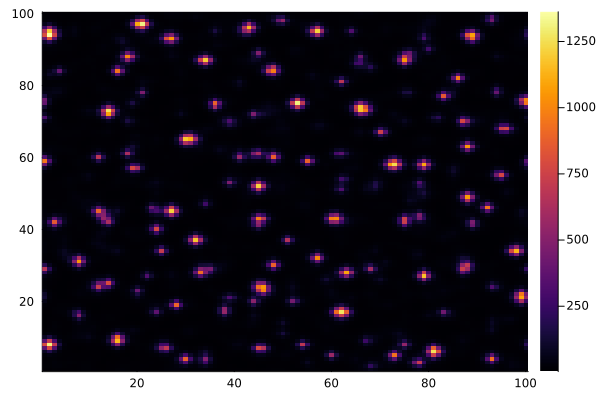

In [6]:
heatmap(sol_n[:,:,1,3])

In [7]:
r = 8
N = 100
SA = 4*pi*r^2
V = (4/3)*pi*r^3
mem_thickness = 0.01
n = (mem_thickness * SA) / V

0.0037500000000000007

In [8]:
sum(sol_n[:,:,1,2]+sol_n[:,:,2,2]./n)

533333.3333333333

In [9]:
sum(sol_n[:,:,1,1]+sol_n[:,:,2,1]./n)

533333.3333333333